In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
# from zeeg_utils import *
from zeeg_utils import map_nan_index
import joblib
import shap
import mne
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

done


In [24]:
all_subjects = ['013', '017', '018', '025', '38', '39', '44', '46', '47', '48', '49', '51', '53']
clean_subj = [s for s in all_subjects if s not in ['018', '39']]

In [25]:
# create dict with all relevant data per subject
# eog1 = joblib.load(f'eog_1.pkl')
# eog2 = joblib.load(f'eog_2.pkl')
# y = joblib.load(f'y_all.pkl')
eog1 = pd.read_csv(f'eog1_mne.csv', dtype={'subj': str}).drop(columns='Unnamed: 0')
eog2 = pd.read_csv(f'eog2_mne.csv', dtype={'subj': str}).drop(columns='Unnamed: 0')
y = joblib.load('y_s20_deepest.pkl')
subj_data = {}
for subj in clean_subj:
    eog1_subj = eog1[eog1['subj'] == subj]
    if subj == '025':
        eog2_subj = eog1_subj
    else:
        eog2_subj = eog2[eog2['subj'] == subj]
    y_subj = y[eog1['subj'] == subj]
    subj_data[subj] = {'eog1': eog1_subj, 'eog2': eog2_subj, 'y': y_subj}

In [26]:
# specific subject
subj = '025'
if subj == '025':
    x = pd.concat([subj_data[subj]['eog1'], subj_data[subj]['eog1']], axis=1, ignore_index=True)
else:
    x = pd.concat([subj_data[subj]['eog1'], subj_data[subj]['eog2']], axis=1, ignore_index=True) 

x.columns = [f'eog1_{col}' for col in subj_data[subj]['eog1'].columns] + [f'eog2_{col}' for col in subj_data[subj]['eog2'].columns]
y = subj_data[subj]['y']

# undersample
rus = RandomUnderSampler(random_state=8)
x, y = rus.fit_resample(x, y)

In [20]:
# combine all subjects
symmetric = True
x = pd.DataFrame()
y = np.array([])
for subj in clean_subj:
# for subj in [s for s in all_subjects if s not in ['018', '39']]:
    eog1_subj = subj_data[subj]['eog1']
    eog2_subj = subj_data[subj]['eog2']
    y_subj = subj_data[subj]['y']
    eog1_subj.reset_index(drop=True, inplace=True)
    eog2_subj.reset_index(drop=True, inplace=True)
    x_subj = pd.concat([eog1_subj, eog2_subj], axis=1, ignore_index=True)
    x_subj.columns = [f'eog1_{col}' for col in eog1_subj.columns] + [f'eog2_{col}' for col in eog2_subj.columns]
    x = pd.concat([x, x_subj], ignore_index=True)
    if symmetric:
        x_sym = pd.concat([eog2_subj, eog1_subj], axis=1, ignore_index=True)
        x_sym.columns = x_subj.columns
        x = pd.concat([x, x_sym], ignore_index=True)
        y = np.concatenate((y, y_subj))
    y = np.concatenate((y, y_subj))

In [ ]:
# combine all subjects with separate eog1 and eog2
eog1 = pd.read_csv(f'eog1_mne.csv', dtype={'subj': str}).drop(columns='Unnamed: 0')
eog2 = pd.read_csv(f'eog2_mne.csv', dtype={'subj': str}).drop(columns='Unnamed: 0')
y_lateral = joblib.load('lateral_y.pkl')
all_results = {}
subj_data = {}
x = pd.DataFrame()
y = np.array([])
# all_subjects = [s for s in all_subjects if s not in [ '39']]
for subj in clean_subj:
    print(f'Processing {subj}')
    eog1_subj = eog1[eog1['subj'] == subj]
    eog2_subj = eog2[eog2['subj'] == subj]
    subj_data[subj] = {'eog1': eog1_subj, 'eog2': eog2_subj, 'y_l': y_lateral[subj].get('L', None), 'y_r': y_lateral[subj].get('R', None)}

for subj in clean_subj:
    print(f'Processing {subj}')
    if subj_data[subj][f'y_l'] is not None and subj_data[subj][f'y_r'] is not None:
        y_subj = np.array(subj_data[subj][f'y_l']) + np.array(subj_data[subj][f'y_r'])
        y_subj = np.where(y_subj > 0, 1, 0)
    else:
        y_subj = subj_data[subj][f'y_l'] if subj_data[subj][f'y_l'] is not None else subj_data[subj][f'y_r']
    for num in range(1, 3):
        x_subj = subj_data[subj][f'eog{num}']      
        if x_subj.shape[0] == 0:
            continue

        # undersample
        rus = RandomUnderSampler(random_state=8)
        x_balanced, y_balanced = rus.fit_resample(x_subj, y_subj)
        
        x = pd.concat([x, x_balanced], ignore_index=True)
        y = np.concatenate((y, y_balanced))

# x['pred'] = y
# sampled_data_0 = pd.DataFrame()
# sampled_data_1 = pd.DataFrame()
# for subj in clean_subj:
#     n_spikes = x[(x['subj'] == subj) & (x['pred'] == 1)].shape[0]
#     print(subj, n_spikes)
#     sample_count = min(3000, n_spikes)
#     sampled_data_0 = pd.concat([sampled_data_0,
#                                 x[(x['subj'] == subj) & (x['pred'] == 0)].sample(sample_count, replace=True,
#                                                                                       random_state=8)])
#     sampled_data_1 = pd.concat([sampled_data_1,
#                                 x[(x['subj'] == subj) & (x['pred'] == 1)].sample(sample_count, replace=True,
#                                                                                       random_state=8)])
# 
# sampled_data = pd.concat([sampled_data_1, sampled_data_0], ignore_index=True)
# x = sampled_data.drop(columns='pred')
# y = sampled_data['pred']

In [5]:
# count number of spikes per subject
x.groupby('eog1_subj').count()

,eog1_epoch_id,eog1_app_entropy,eog1_decorr_time,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,eog1_higuchi_fd,...,eog2_energy_freq_bands_st,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_energy_freq_bands_ft,eog2_chan_name,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt
eog1_subj,,,,,,,,,,,,,,,,,,,,,
013,108852,108852,108852,108852,108852,108852,108852,108852,108852,108852,...,108852,108852,108852,108852,108852,108852,108852,108852,108852,108852
017,138079,138079,138079,138079,138079,138079,138079,138079,138079,138079,...,138079,138079,138079,138079,138079,138079,138079,138079,138079,138079
025,117088,117088,117088,117088,117088,117088,117088,117088,117088,117088,...,117088,117088,117088,117088,117088,117088,117088,117088,117088,117088
38,140986,140986,140986,140986,140986,140986,140986,140986,140986,140986,...,140986,140986,140986,140986,140986,140986,140986,140986,140986,140986
44,136081,136081,136081,136081,136081,136081,136081,136081,136081,136081,...,136081,136081,136081,136081,136081,136081,136081,136081,136081,136081
46,120999,120999,120999,120999,120999,120999,120999,120999,120999,120999,...,120999,120999,120999,120999,120999,120999,120999,120999,120999,120999
47,128327,128327,128327,128327,128327,128327,128327,128327,128327,128327,...,128327,128327,128327,128327,128327,128327,128327,128327,128327,128327
48,85415,85415,85415,85415,85415,85415,85415,85415,85415,85415,...,85415,85415,85415,85415,85415,85415,85415,85415,85415,85415
49,21774,21774,21774,21774,21774,21774,21774,21774,21774,21774,...,21774,21774,21774,21774,21774,21774,21774,21774,21774,21774


In [14]:
x['pred'] = y
sampled_data_0 = pd.DataFrame()
sampled_data_1 = pd.DataFrame()
min_samples = 3000
for subj in clean_subj:
# for subj in [s for s in all_subjects if s not in ['018', '39']]:
    n_spikes = x[(x['eog1_subj'] == subj) & (x['pred'] == 1)].shape[0]
    print(subj, n_spikes)
    sample_count = min(min_samples, n_spikes)
    sampled_data_0 = pd.concat([sampled_data_0, x[(x['eog1_subj'] == subj) & (x['pred'] == 0)].sample(sample_count, replace=True, random_state=8)])
    sampled_data_1 = pd.concat([sampled_data_1, x[(x['eog1_subj'] == subj) & (x['pred'] == 1)].sample(sample_count, replace=True, random_state=8)])

sampled_data = pd.concat([sampled_data_1, sampled_data_0], ignore_index=True)
x = sampled_data.drop(columns='pred')
y = sampled_data['pred']
sampled_data

013 18296
017 12976
025 870
38 51132
44 14060
46 1846
47 5806
48 4890
49 934
51 16502
53 6512


,eog1_subj,eog1_epoch_id,eog1_app_entropy,eog1_decorr_time,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,...,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_energy_freq_bands_ft,eog2_chan_name,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt,pred
0,013,62688,0.074922,0.037,1.030101,0.739969,0.664795,0.428142,0.114624,0.003940,...,5.762484,74.535468,0.182924,12.934608,0.014142,EOG2,42.421705,-0.440633,18.241874,1.0
1,013,43380,0.230544,0.032,0.127198,0.694453,1.135672,0.539721,0.129658,0.010781,...,9.480921,130.292377,0.491717,13.742586,0.035781,EOG2,42.421705,-0.440633,18.241874,1.0
2,013,16769,0.196957,0.046,0.335683,0.283568,0.222127,0.486723,0.031543,0.002549,...,2.840335,99.220864,0.262025,34.932804,0.007501,EOG1,56.238462,-0.031953,11.273969,1.0
3,013,87313,0.062387,-1.000,0.181049,0.126395,0.057626,0.093919,0.135132,0.001769,...,0.143959,3.791296,3.750285,26.335852,0.142402,EOG2,42.421705,-0.440633,18.241874,1.0
4,013,67755,0.096882,-1.000,0.696685,0.842979,0.472139,0.448411,0.121146,0.007973,...,5.202469,29.554351,0.095578,5.680832,0.016825,EOG2,42.421705,-0.440633,18.241874,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55295,53,68053,0.028556,-1.000,0.005760,0.004638,0.003096,0.007384,0.003927,0.000090,...,0.687802,89.031916,4.279322,129.444164,0.033059,EOG1,99.300294,2.706403,109.848260,0.0
55296,53,17828,0.081745,-1.000,0.005672,0.001315,0.004332,0.006742,0.003801,0.000059,...,1.568995,98.192474,1.765209,62.583048,0.028206,EOG1,99.300294,2.706403,109.848260,0.0
55297,53,23560,0.442872,0.014,0.000373,0.005009,0.008388,0.079467,0.081920,0.000268,...,0.458800,9.312092,0.384269,20.296634,0.018933,EOG2,74.714827,-14.860522,620.927288,0.0
55298,53,67245,0.081750,-1.000,0.809874,0.500360,0.128786,0.288108,0.088505,0.001060,...,0.036938,8.582519,4.467149,232.351854,0.019226,EOG2,74.714827,-14.860522,620.927288,0.0


In [81]:
sampled_data.groupby('eog1_subj')['pred'].sum()

eog1_subj
013    3000.0
017    3000.0
025     435.0
38     3000.0
44     3000.0
46     1846.0
47     3000.0
48     3000.0
49      934.0
51     3000.0
53     3000.0
Name: pred, dtype: float64

In [27]:
meta_data = ['subj', 'epoch_id', 'chan_name', 'epoch']
feat_to_choose = ['teager_kaiser_energy_1_std', 'teager_kaiser_energy_2_std', 'chan_ptp', 'ptp_amp', 'hjorth_mobility', 'hjorth_complexity', 'teager_kaiser_energy_3_std', 'chan_kurt', 'teager_kaiser_energy_5_mean', 'teager_kaiser_energy_0_std', 'kurtosis', 'teager_kaiser_energy_0_mean', 'teager_kaiser_energy_1_mean', 'teager_kaiser_energy_5_std', 'samp_entropy']
feat_to_choose2 = ['chan', 'bands_gf', 'bands_gamma', 'bands_fast', 'bands_beta/gamma', 'bands_theta/fast', 'ptp', 'skew', 'teager', 'bands_sf', 'bands_bf', 'bands_bg', 'rms', 'katz', 'kurt', 'slope', 'mobility', 'hurst', 'wavelet']
feat_to_choose3 = ['chan', 'bands_gf', 'bands_gamma', 'energy_freq_bands_fast', 'bands_beta/gamma', 'bands_theta/fast', 'ptp', 'skew', 'teager', 'bands_sf', 'bands_bf', 'rms', 'kurt', 'slope', 'mobility', 'eog1_wavelet_coef_energy_0']
remove_3 = ['gamma/beta', 'fast/theta', 'fast/gamma']
remove_4 = ['gamma/sigma', 'fast/alpha', 'coef_1', '2_mean']
# remove meta data
# x_feat = x[x.columns[~x.columns.isin(meta_data)]]
# x_feat = x[x.columns[~x.columns.str.contains('|'.join(meta_data))]]
# get only columns that contain the string in feat_to_choose
x_feat = x[x.columns[x.columns.str.contains('|'.join(feat_to_choose2))]]
x_feat = x_feat[x_feat.columns[~x_feat.columns.str.contains('|'.join(meta_data+remove_3))]]
# x_feat = x[x.columns[~x.columns.isin(meta_data)]]
# x_feat = x[feat_to_choose]
x_feat

,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,eog1_hjorth_mobility,eog1_hjorth_mobility_spect,eog1_hurst_exp,eog1_katz_fd,eog1_kurtosis,eog1_pow_freq_bands_gamma,eog1_pow_freq_bands_fast,eog1_pow_freq_bands_theta/fast,...,eog2_wavelet_coef_energy_2,eog2_wavelet_coef_energy_3,eog2_wavelet_coef_energy_4,eog2_energy_freq_bands_bg,eog2_energy_freq_bands_bf,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gf,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt
269902,0.044099,0.003105,0.072805,1.411922,-1.138021,1.283162,2.293746,0.021607,0.000986,459.047839,...,0.023160,0.175969,1.412389,1.848450,26.254304,18.828148,14.203415,81.799603,-0.231181,30.222338
290336,0.025574,0.003849,0.059337,2.211027,-4.978503,1.214948,2.555461,0.006353,0.000772,552.317262,...,0.081285,0.151531,2.036928,1.214972,8.073622,29.479016,6.645112,81.799603,-0.231181,30.222338
362663,0.122827,0.002231,0.141888,2.464345,0.894521,1.271468,2.232779,0.037930,0.001288,323.825386,...,0.028554,0.235355,2.051393,0.728271,40.093011,15.415723,55.052302,81.799603,-0.231181,30.222338
293200,0.063970,0.003152,0.143251,2.959696,0.892811,1.200630,2.657331,0.013389,0.000701,705.051040,...,0.040571,0.148639,1.387370,1.231643,24.994000,7.457189,20.293226,81.799603,-0.231181,30.222338
325259,0.048964,0.002387,0.122368,1.259515,-3.787737,1.281446,1.924402,0.046761,0.001163,383.759780,...,0.013204,0.156386,1.429471,2.511773,51.527899,9.790214,20.514556,81.799603,-0.231181,30.222338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364538,0.047028,0.003323,0.111057,5.337485,-3.613221,1.083379,1.833129,0.007309,0.001334,378.530502,...,0.048621,0.125981,3.034994,2.361970,33.428388,54.107962,14.152758,81.799603,-0.231181,30.222338
366387,0.032848,0.002516,0.068831,2.446389,1.243070,1.237500,1.768946,0.004112,0.000048,11245.905082,...,0.006915,0.273392,1.008881,1.938466,25.313006,6.143002,13.058267,81.799603,-0.231181,30.222338
366860,0.035930,0.002546,0.044660,2.092987,0.802321,1.254988,1.804262,0.004417,0.000549,926.970186,...,0.007347,0.135723,3.543706,3.311666,46.731633,58.975295,14.111215,81.799603,-0.231181,30.222338
376496,0.014246,0.004096,0.064084,14.248663,-2.298911,1.473339,2.023705,0.003840,0.000323,1271.982059,...,0.051849,0.264138,8.063730,13.674398,47.554613,106.226115,3.477639,81.799603,-0.231181,30.222338


In [28]:
# save models
n_s = x['eog1_subj'].nunique()
n_f = x_feat.shape[1]
sym = 'sym' if symmetric else 'asym'
balance = 'b' if sum(y) / len(y) == 0.5 else 'ub'
name = f's{n_s}_f{n_f}_{balance}_{sym}'
name

's1_f98_b_asym'

In [29]:
model = xgb.XGBClassifier()
model.fit(x_feat, y)
joblib.dump(model, f'validation_models_v2/xgb_{name}.pkl')
model = LGBMClassifier()
model.fit(x_feat, y)
joblib.dump(model, f'validation_models_v2/lgbm_{name}.pkl')
model = RandomForestClassifier()
model.fit(x_feat, y)
joblib.dump(model, f'validation_models_v2/rf_{name}.pkl')

[LightGBM] [Info] Number of positive: 435, number of negative: 435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23460
[LightGBM] [Info] Number of data points in the train set: 870, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


['validation_models_v2/rf_s1_f98_b_asym.pkl']

In [7]:
metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
i = 1
for train_index, test_index in kf.split(x_feat, y):
    print(f'Fold {i}')
    i += 1
    # model = xgb.XGBClassifier()
    # model = LGBMClassifier()
    model = RandomForestClassifier()
    x_train_fold, x_test_fold = x_feat.iloc[train_index], x_feat.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model.fit(x_train_fold, y_train_fold)
    y_pred = model.predict(x_test_fold)
    y_true = y_test_fold
    # save scores in dict
    metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['precision'].append(precision_score(y_true, y_pred))
    metrics['sensitivity'].append(recall_score(y_true, y_pred))
    metrics['f1'].append(f1_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'].append(tn / (tn + fp))
    metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
    metrics['PRAUC'].append(average_precision_score(y_true, y_pred))
    # metrics['FP/min'].append(fp / (len(test_index) / 4))

# print results as df
results = pd.DataFrame(metrics)
# add mean row
results.loc['mean'] = results.mean()
print(sum(y)/len(y))
results

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
0.5


,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
0,0.712659,0.713857,0.709858,0.715459,0.711852,0.712659,0.651808
1,0.717980,0.713086,0.729462,0.706497,0.721181,0.717980,0.655438
2,0.711538,0.707966,0.720127,0.702950,0.713995,0.711538,0.649762
3,0.716766,0.718233,0.713406,0.720127,0.715811,0.716766,0.655689
4,0.717420,0.717867,0.716393,0.718447,0.717129,0.717420,0.656078
mean,0.715273,0.714202,0.717849,0.712696,0.715994,0.715273,0.653755


In [127]:
# leave one subject out
metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
# if col exist rename it
if 'eog1_subj' in x.columns:
    x.rename(columns={'eog1_subj': 'subj'}, inplace=True)
for subj in clean_subj:
    print(f'Processing {subj}')
    x_train = x_feat[x['subj'] != subj]
    y_train = y[x['subj'] != subj]
    x_test = x_feat[x['subj'] == subj]
    y_test = y[x['subj'] == subj]
    # model = xgb.XGBClassifier()
    # model = LGBMClassifier()
    model = RandomForestClassifier()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_true = y_test
    # save scores in dict
    metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['precision'].append(precision_score(y_true, y_pred))
    metrics['sensitivity'].append(recall_score(y_true, y_pred))
    metrics['f1'].append(f1_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'].append(tn / (tn + fp))
    metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
    metrics['PRAUC'].append(average_precision_score(y_true, y_pred))
    # metrics['FP/min'].append(fp / (len(test_index) / 4))
    
# print results as df
results = pd.DataFrame(metrics, index=clean_subj)
# add mean row
results.loc['mean'] = results.mean()
results

Processing 013
Processing 017
Processing 38
Processing 44
Processing 46
Processing 47
Processing 48
Processing 49
Processing 51
Processing 53


,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
013,0.639500,0.632479,0.666000,0.613000,0.648807,0.639500,0.588231
017,0.596167,0.719392,0.315333,0.877000,0.438470,0.596167,0.569181
38,0.612667,0.586578,0.763333,0.462000,0.663384,0.612667,0.566088
44,0.624667,0.651663,0.535667,0.713667,0.587999,0.624667,0.581241
46,0.601571,0.607204,0.575298,0.627844,0.590821,0.601571,0.561674
47,0.518167,0.653521,0.077333,0.959000,0.138301,0.518167,0.511872
48,0.642000,0.715152,0.472000,0.812000,0.568675,0.642000,0.601552
49,0.562634,0.656000,0.263383,0.861884,0.375859,0.562634,0.541088
51,0.554167,0.538047,0.766000,0.342333,0.632100,0.554167,0.529144
53,0.486667,0.426199,0.077000,0.896333,0.130435,0.486667,0.494317


In [ ]:
# use shap to explain model predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_fold)
shap.summary_plot(shap_values, x_test_fold)

In [8]:
# print feature importance with colmn name
# feature_importance = pd.DataFrame(model.feature_importances_, index=x_feat.columns, columns=['importance'])
feature_importance = pd.DataFrame(model.feature_importances_, index=x_feat.columns, columns=['importance'])
feature_importance.sort_values(by='importance', ascending=False)

,importance
eog1_teager_kaiser_energy_0_mean,0.016049
eog2_teager_kaiser_energy_0_mean,0.015744
eog1_spect_slope_intercept,0.015342
eog1_pow_freq_bands_beta/gamma,0.014871
eog1_pow_freq_bands_gamma,0.014787
...,...
eog1_chan_kurt,0.004433
eog1_chan_skew,0.004345
eog2_chan_skew,0.004269
eog2_chan_ptp,0.003598


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


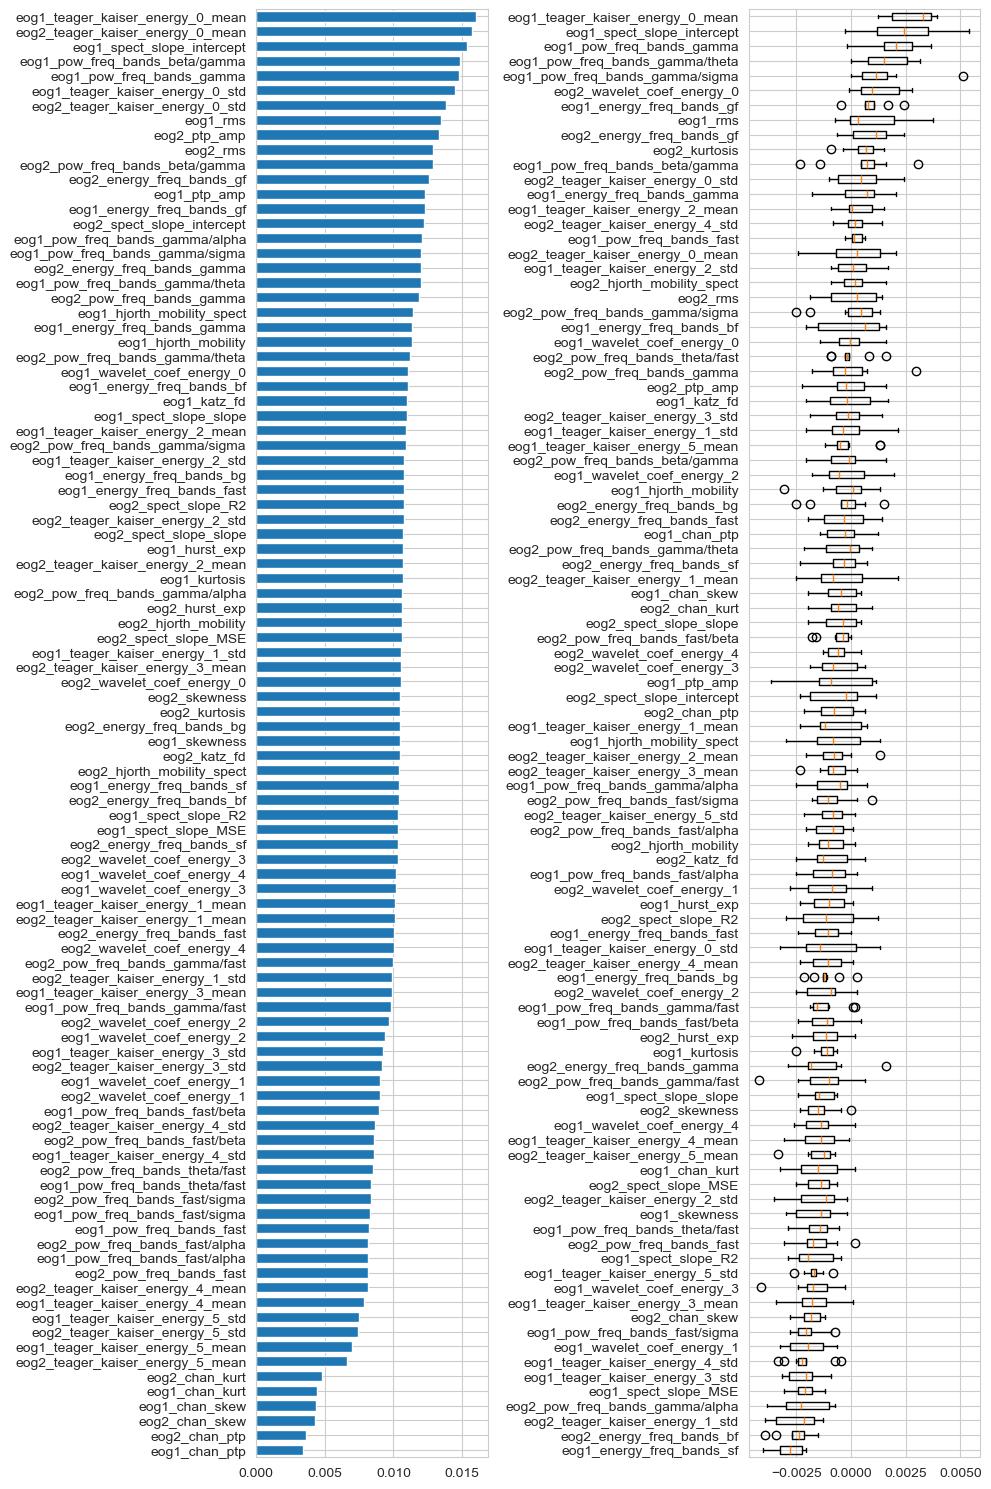

In [9]:
# permutation importance
from sklearn.inspection import permutation_importance
result = permutation_importance(model, x_test_fold, y_test_fold, n_repeats=10, random_state=8, n_jobs=2)
perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_indices = np.arange(0, len(model.feature_importances_)) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15))
ax1.barh(tree_indices, model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(x_test_fold.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=x_test_fold.columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

In [355]:
plt.figure(figsize=(8,8))
pai = x[y==1]['subj'].value_counts()
plt.pie(x=pai, labels=pai.index, startangle=30, autopct='%1.2f%%', pctdistance=0.80, explode=[0.05] * len(pai))
### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)

KeyError: 'subj'

<Figure size 800x800 with 0 Axes>

In [31]:
x[x['subj'] == '025']

,subj,eog1_epoch_id,eog1_app_entropy,eog1_decorr_time,eog1_energy_freq_bands_theta,eog1_energy_freq_bands_alpha,eog1_energy_freq_bands_sigma,eog1_energy_freq_bands_beta,eog1_energy_freq_bands_gamma,eog1_energy_freq_bands_fast,...,eog2_energy_freq_bands_st,eog2_energy_freq_bands_sg,eog2_energy_freq_bands_sf,eog2_energy_freq_bands_gt,eog2_energy_freq_bands_gf,eog2_energy_freq_bands_ft,eog2_chan_name,eog2_chan_ptp,eog2_chan_skew,eog2_chan_kurt
6000,025,74358,0.114444,-1.000,0.259685,0.009663,0.023394,0.078648,0.025478,0.002624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6001,025,89798,0.109050,0.037,0.101114,0.127873,0.043052,0.064266,0.061337,0.002904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6002,025,32743,0.115349,-1.000,0.237513,0.325202,0.091924,0.125625,0.048809,0.002522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6003,025,32902,0.073304,-1.000,0.484418,0.667420,0.097008,0.091827,0.048066,0.004369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6004,025,74027,0.077945,0.037,0.091789,0.060968,0.023774,0.095241,0.049058,0.003048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28603,025,3294,0.231944,0.041,0.065506,0.119948,0.135136,0.130295,0.145839,0.003147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28604,025,64472,0.129608,0.037,0.109971,0.041539,0.010605,0.033096,0.053188,0.002606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28605,025,35844,0.046664,-1.000,0.189956,0.279962,0.078850,0.095197,0.020067,0.002482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28606,025,115139,0.120340,-1.000,0.026477,0.020320,0.023047,0.076278,0.034662,0.002455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
subj = '025'
y_depth = subj_data[subj]['y_l']
subj_feat = subj_data[subj]['eog1']
subj_feat = subj_feat[subj_feat.columns[subj_feat.columns.str.contains('|'.join(feat_to_choose2))]]
subj_feat = subj_feat[subj_feat.columns[~subj_feat.columns.str.contains('|'.join(meta_data))]]
y_proba = model.predict_proba(subj_feat).T
y_scalp = [p > 0.8 for p in y_proba[1]]
print(sum(y_scalp), sum(y_depth))
index_map = map_nan_index('D:\\TLV\\%s_clean_mtl_annot.fif' % subj)
#some problem with empty y_scalp
scalp_indexes = np.where(y_scalp == True)[0]
scalp_onsets = [index_map[int(x)] / 4 for x in scalp_indexes]
depth_indexes = np.where(y_depth == 1)[0]
depth_onsets = [index_map[int(x)] / 4 for x in depth_indexes]
both = [x for x in scalp_onsets if x in depth_onsets]
raw = mne.io.read_raw('D:\\TLV\\%s_clean_mtl_annot.fif' % subj)
# all annot
annot = mne.Annotations(scalp_onsets, [0.25] * len(scalp_onsets), ['scalp'] * len(scalp_onsets)).append(depth_onsets, [0.25] * len(depth_onsets), ['depth'] * len(depth_onsets)).append(both, [0.25] * len(both), ['both'] * len(both))
# only depth and both
annot = mne.Annotations(depth_onsets, [0.25] * len(depth_onsets), ['depth'] * len(depth_onsets)).append(both, [0.25] * len(both), ['both'] * len(both))
# only both
# annot = mne.Annotations(both, [0.25] * len(both), ['both'] * len(both))
raw.set_annotations(annot)
# mne.set_bipolar_reference(raw, raw.ch_names[0], raw.ch_names[1], ch_name='bi', drop_refs=False).plot(
#     duration=30, scalings='auto')

raw.crop(tmin=0, tmax=60*60*3).plot(duration=30, scalings='auto')

ValueError: Feature shape mismatch, expected: 104, got 52

In [270]:
y_scalp

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [265]:
y_scalp

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [262]:
scalp_indexes

array([], dtype=int64)